## 2nd Team Project (Classificaiton) Instacart 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br><br><br><br><br><br><br>

                                                                                 - 조이름: 127.0.0.1 (김소령, 안용성, 박정호, 권수환)

### 0. Library Import & Data Loading

In [83]:
import pandas as pd
import numpy as np
import gc # Garbage Collector interface
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [122]:
# data loading
aisles = pd.read_csv('./input/aisles.csv')
dep = pd.read_csv('./input/departments.csv')
ord_prd_pr = pd.read_csv('./input/order_products__prior.csv')
ord_prd_tr = pd.read_csv('./input/order_products__train.csv')
orders = pd.read_csv('./input/orders.csv')
products = pd.read_csv('./input/products.csv')

In [123]:
# Changing some columns types to int for less memory usage
aisles['aisle'] = aisles['aisle'].astype('category')
dep['department'] = dep['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

orders.order_dow = orders.order_dow.astype(np.int8)
orders.order_hour_of_day = orders.order_hour_of_day.astype(np.int8)
orders.order_number = orders.order_number.astype(np.int16)
orders.order_id = orders.order_id.astype(np.int32)
orders.user_id = orders.user_id.astype(np.int32)
orders.days_since_prior_order = orders.days_since_prior_order.astype(np.float32)

products.drop(['product_name'], axis=1, inplace=True)
products.aisle_id = products.aisle_id.astype(np.int8)
products.department_id = products.department_id.astype(np.int8)
products.product_id = products.product_id.astype(np.int32)

ord_prd_tr.reordered = ord_prd_tr.reordered.astype(np.int8)
ord_prd_tr.add_to_cart_order = ord_prd_tr.add_to_cart_order.astype(np.int16)

ord_prd_pr.order_id = ord_prd_pr.order_id.astype(np.int32)
ord_prd_pr.add_to_cart_order = ord_prd_pr.add_to_cart_order.astype(np.int16)
ord_prd_pr.reordered = ord_prd_pr.reordered.astype(np.int8)
ord_prd_pr.product_id = ord_prd_pr.product_id.astype(np.int32)

In [124]:
print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))
print('products {}: {}'.format(products.shape, ', '.join(products.columns)))
print('ord_prd_tr {}: {}'.format(ord_prd_tr.shape, ', '.join(ord_prd_tr.columns)))
print('ord_prd_pr {}: {}'.format(ord_prd_pr.shape, ', '.join(ord_prd_pr.columns)))

orders (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
products (49688, 3): product_id, aisle_id, department_id
ord_prd_tr (1384617, 4): order_id, product_id, add_to_cart_order, reordered
ord_prd_pr (32434489, 4): order_id, product_id, add_to_cart_order, reordered


### 1. EDA

#### (1)  Orders data -> prior, train, test set 확인 

* eval_set기준으로 분류

In [79]:
cnt_df = orders.eval_set.value_counts()
cnt_df

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

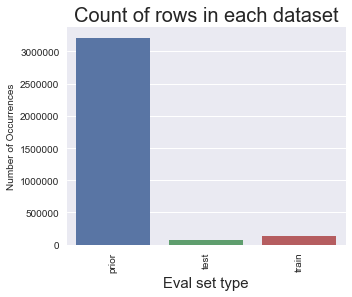

In [90]:
plt.figure(figsize= (5,4))
sns.barplot(cnt_df.index, cnt_df.values)
plt.ylabel('Number of Occurrences',fontsize = 10)
plt.xlabel('Eval set type', fontsize = 15)
plt.title('Count of rows in each dataset', fontsize = 20)
plt.xticks(rotation = 'vertical')
plt.show()

#### (2) 목표

* : 1. 유저별로 재구매할 품목들은 무엇인가?
* : 2. 유저별로 새롭게 구매할 품목은 어떻게 예측할 것인가?


![reg tree](https://files.slack.com/files-pri/T5AP56SQ3-F6E6F1RNU/foreign_key.png)

MySQL에서 돌려보기위해 foreign key column 확인

#### (3) 인스타카트 서비스 조사

*  배송료가 높다면 1)한번에 사는 물품이 많을 것이라 가정하였고, 2)주문 기간에도 영향을 줄것이라 생각했다.  
     ((1) user_average_basket Feautures, (2)user_period를 만드는데 반영된다.)   
*  그러나 인스타카트 Express라는 회원제(월 12.99)제도 때문에 영향이 주문 기간, 횟수에는 영향이 없었다.
   
*  35불이하로 구매하면 추가되는 요금 때문에 average_basket에는 영향이 있음을(주문당 구매량이 큼)을 확인 할 수 있었다.     

![fee](https://files.slack.com/files-tmb/T5AP56SQ3-F6E9YMJFK-81e2e9092a/fee_1024.png)

### 2. Feature Engineering

In [76]:
data_ = {'Product_Features': ['prod_average_cart_position','prod_orders','prod_reorder_probability', 'prod_reorder_times','prod_reorder_ratio','-','-','-','-'],
        'User_Features' : ['user_orders', 'user_period', 'user_mean_days_since_prior', 'user_total_products','user_reorder_ratio',
                            'user_distinct_products','user_reorder_ratio','user_distinct_products','user_average_basket'],
        'User_Products_interaction': ['up_orders','up_first_orders', 'up_last_orders','up_average_cart_position','up_order_rate',
                                      'up_orders_since_last_order','up_order_rate_since_first_order','-','-'],
        'Recency' : ['days_since_prior_order', '-','-','-','-','-','-','-','-']}

frame = pd.DataFrame(data_, index = [1,2,3,4,5,6,7,8,9])

In [77]:
frame

,Product_Features,Recency,User_Features,User_Products_interaction
1,prod_average_cart_position,days_since_prior_order,user_orders,up_orders
2,prod_orders,-,user_period,up_first_orders
3,prod_reorder_probability,-,user_mean_days_since_prior,up_last_orders
4,prod_reorder_times,-,user_total_products,up_average_cart_position
5,prod_reorder_ratio,-,user_reorder_ratio,up_order_rate
6,-,-,user_distinct_products,up_orders_since_last_order
7,-,-,user_reorder_ratio,up_order_rate_since_first_order
8,-,-,user_distinct_products,-
9,-,-,user_average_basket,-


#### (1) Product data reshaping (products + department + aisles)

In [125]:
df_products = pd.merge(left = products, right = dep, on = 'department_id', how = 'left')
goods = pd.merge(left = df_products, right = aisles, on = 'aisle_id', how = 'left')
goods.tail(3)

,product_id,aisle_id,department_id,department,aisle
49685,49686,112,3,bakery,bread
49686,49687,41,8,pets,cat food care
49687,49688,73,11,personal care,facial care


In [126]:
goods.drop(['department_id'], axis = 1, inplace = True)
goods.drop(['aisle_id'], axis = 1, inplace = True)
goods.tail(3)

,product_id,department,aisle
49685,49686,bakery,bread
49686,49687,pets,cat food care
49687,49688,personal care,facial care


#### (2) Product data (5)

1. 카트에 담긴 순서의 평균 (먼저 담을수록 재구매 확률이 높을 것이라는 가정)
2. 총주문횟수 (주문이 많이 될 수록 재구매 확률도 높을 것이라는 가정)
3. 재구매될 확률 (조건부 확률 이용. (두번째 주문 / 첫번째 주문))
4. 재주문 횟수의 평균 (재주문 많이 될수록 재구매 확률도 높을 것이라는 가정)
5. 전체 주문 중 재구매된 비율

In [127]:
ord_prd_tr = ord_prd_tr.merge(orders[['user_id','order_id']], left_on = 'order_id', right_on = 'order_id', how = 'inner')

In [128]:
orders_products_pr = orders.merge(ord_prd_pr, how = 'inner', on = 'order_id')

In [129]:
# sorting orders and products to get the rank or the reorder times for the product
prdss = orders_products_pr.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)

In [130]:
prdot = orders_products_pr.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)

In [131]:
prdot.shape

(32434489, 10)

In [132]:
# product time 생성: 유저별 & 제품별 구매 횟수
prdss = prdss.assign(product_time = prdss.groupby(['user_id', 'product_id']).cumcount()+1)

In [133]:
# prod_average_cart_position: 제품별 평균 카트에 담긴 순서
sub = prdss.groupby(['product_id'])['add_to_cart_order'].mean().to_frame('prod_average_cart_position')

In [134]:
# getting products ordered first and second times 나중에 확률 계산을 하기 위해 
# sub1: 제품별 첫번째로 구매한 횟수, 
# sub2: 제품별 두번째로 구매한 횟수
sub1 = prdss[prdss['product_time'] == 1].groupby('product_id').size().to_frame('prod_first_orders')
sub2 = prdss[prdss['product_time'] == 2].groupby('product_id').size().to_frame('prod_second_orders')

In [135]:
# sub1에 prod_orders 추가: 제품별 총구매횟수
sub1['prod_orders'] = prdss.groupby('product_id')['product_id'].size()

In [136]:
# sub1에 prod_reorders 추가: 제품별 재구매횟수
# prod_orders(제품별 총구매횟수) = prod_first_orders (제품별 첫번째 주문횟수) + prod_reorders (제품별 재구매횟수)
sub1['prod_reorders'] = prdss.groupby('product_id')['reordered'].sum()

In [137]:
# sub1과 sub2 합침
sub2 = sub2.reset_index().merge(sub1.reset_index())

In [138]:
print('sub2 {}: {}'.format(sub2.shape, ', '.join(sub2.columns)))

sub2 (45305, 5): product_id, prod_second_orders, prod_first_orders, prod_orders, prod_reorders


In [139]:
# calculating reorder probability and ratio for the product
# 'prod_reorder_probability' : 제품별 재구매 될 확률 (= 제품별 2번째 구매횟수 / 제품별 첫구매횟수)
sub2['prod_reorder_probability'] = sub2['prod_second_orders']/sub2['prod_first_orders']

In [140]:
# 'prod_reorder_times' 제품 평균 재주문 횟수 : 1 + (제품별 재구매 횟수 /제품별 첫구매횟수) 
sub2['prod_reorder_times'] = 1 + sub2['prod_reorders']/sub2['prod_first_orders']

In [141]:
# 'prod_reorder_ratio' 재구매 비율 = 재구매 횟수 / 총주문 횟수
sub2['prod_reorder_ratio'] = sub2['prod_reorders']/sub2['prod_orders']

In [142]:
prd = sub2[['product_id', 'prod_orders','prod_reorder_probability', 'prod_reorder_times', 'prod_reorder_ratio']]

In [143]:
# Memory cleaning 
del sub1, sub2
gc.collect()

22436

#### (3) User Data (7)

(User의 특성 파악)
6. 총주문 횟수 (얼마나 많이 주문하는지)
7. 다음 주문까지의 기간의 합계 (얼마나 자주 주문하는지)
8. 다음 주문까지의 평균 소요일 (얼마나 자주(빨리) 주문하는지)
9. 총 주문 제품 개수 (얼마나 많은 제품을 주문하는지)
10. 재구매 비율 (특정 제품을 얼마나 다시 주문하는지)
11. 주문한 제품의 종류 (가지수) (얼마나 다양한 제품을 주문하는지)
12. 주문 당 평균 제품 개수 (한번에 얼마나 많이 주문하는지)

In [144]:
# user_orders 생성 - 유저별로 order 한 횟수
users = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['order_number'].max().to_frame('user_orders')

In [145]:
print('users {}: {}'.format(users.shape, ', '.join(users.columns)))

users (206209, 1): user_orders


In [146]:
# user_period 생성 - 이전 오더 이후 주문일 합계
users['user_period'] = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['days_since_prior_order'].sum()

In [147]:
# user_mean_days_since_prior 생성 - 평균 주문소요일
users['user_mean_days_since_prior'] = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['days_since_prior_order'].mean()

In [148]:
# merging features about users and orders into one dataset
# user_total_products 생성 - user id 별 주문한 product의 수
us = orders_products_pr.groupby('user_id').size().to_frame('user_total_products')

In [149]:
# eq_1 - 그 중 재주문한 product의 수
us['eq_1'] = orders_products_pr[orders_products_pr['reordered'] == 1].groupby('user_id')['product_id'].size()

In [150]:
# qt_1 - 유저별로 첫번째 주문을 제외한 주문의 product의 수
us['gt_1'] = orders_products_pr[orders_products_pr['order_number'] > 1].groupby('user_id')['product_id'].size()

In [151]:
# user_reorder_ratio: user 별 재구매 비율 (=재주문한 product의 수 / 첫번째 주문을 제외한 주문의 product의 수)
us['user_reorder_ratio'] = us['eq_1'] / us['gt_1']

In [152]:
us.drop(['eq_1', 'gt_1'], axis = 1, inplace = True)

In [153]:
# user_distinct_products: user 별 주문한 product 종류의 수
us['user_distinct_products'] = orders_products_pr.groupby(['user_id'])['product_id'].nunique()

In [154]:
# users와 us 결합
users = users.reset_index().merge(us.reset_index())

In [155]:
# user_average_basket : 유저별 주문당 평균 제품 개수
users['user_average_basket'] = users['user_total_products'] / users['user_orders']

In [156]:
# test, train order 만..
us2 = orders[orders['eval_set'] != 'prior'] 

In [157]:
us2 = us2[['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]

In [158]:
users = users.merge(us2)

In [159]:
print('users {}: {}'.format(users.shape, ', '.join(users.columns)))

users (206209, 11): user_id, user_orders, user_period, user_mean_days_since_prior, user_total_products, user_reorder_ratio, user_distinct_products, user_average_basket, order_id, eval_set, days_since_prior_order


#### (4) Order data (related with User & Product data)  (7)
(프로젝트 목표: Test user의 최종 주문한 제품의 재구매 여부 구하는 것 -> User와 Product 복합된 feature 필요) 
1. user별 특정 제품의 총 주문 횟수
2. user별 특정 제품을 최초 주문한 주문순번
3. user별 특정 제품을 마지막으로 주문한 주문순번
4. user별 특정 제품이 장바구니에 담긴 순번의 평균
5. 특정 user가 특정 제품을 주문한 비율 (유저별/제품별 주문횟수 / 유저별 총 주문수)
6. 특정 user가 특정 제품을 마지막으로 주문한 이후 그 제품이 없는 주문의 횟수 (값이 낮을 수록 최근에 구매함)
7. 첫번째 주문 이후 유저별/제품별 주문율

(주어진 dataset에서) 1. 주문 후 재주문까지의 기간  

In [160]:
# up_orders: user, product 별 주문수
data = orders_products_pr.groupby(['user_id', 'product_id']).size().to_frame('up_orders')

In [161]:
# up_first_order: 해당 product를 최초 주문한 주문순서
data['up_first_order'] = orders_products_pr.groupby(['user_id', 'product_id'])['order_number'].min()

In [162]:
# up_last_order: 해당 product를 최초 주문한 주문순서
data['up_last_order'] = orders_products_pr.groupby(['user_id', 'product_id'])['order_number'].max()

In [163]:
# avg_cart_position : 제품별로 cart에 담은 순서의 평균 
data['up_average_cart_position'] = orders_products_pr.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean()
data = data.reset_index()

In [164]:
# user, product data와 결합
data = data.merge(prd, on = 'product_id')
data = data.merge(users, on = 'user_id')

In [165]:
print('data {}: {}'.format(data.shape, ', '.join(data.columns)))

data (13278023, 20): user_id, product_id, up_orders, up_first_order, up_last_order, up_average_cart_position, prod_orders, prod_reorder_probability, prod_reorder_times, prod_reorder_ratio, user_orders, user_period, user_mean_days_since_prior, user_total_products, user_reorder_ratio, user_distinct_products, user_average_basket, order_id, eval_set, days_since_prior_order


In [166]:
# up_order_rate 유저별/제품별 주문비율 : 유저별/제품별 주문횟수 / 유저별 총 주문수
data['up_order_rate'] = data['up_orders'] / data['user_orders']

In [167]:
# up_orders_since_last_order 제품별 최종 주문 이후 유저 주문수: 유저별 총 주문수 - 유저별/제품별 최종 주문수
data['up_orders_since_last_order'] = data['user_orders'] - data['up_last_order']

In [168]:
# up_order_rate_since_first_order 
# 첫번째 주문 이후 유저별/제품별 주문율 : 유저별/제품별 주문수 / (유저별 총주문수 - 유저별/제품별 최초주문순서 + 1)
data['up_order_rate_since_first_order'] = data['up_orders'] / (data['user_orders'] - data['up_first_order'] + 1)

In [169]:
# reordered 추가
data = data.merge(ord_prd_tr[['user_id', 'product_id', 'reordered']], how = 'left', on = ['user_id', 'product_id'])

In [170]:
data.tail(3)

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,...,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,reordered
13278020,166751,49001,3,1,3,1.0,45,0.193548,1.451613,0.311111,...,1.0,1,1.0,2080697,train,14.0,1.0,0,1.0,1.0
13278021,106143,19675,26,1,26,1.0,39,0.833333,6.500000,0.846154,...,1.0,1,1.0,1714200,test,9.0,1.0,0,1.0,NaN
13278022,66343,47210,4,1,4,1.0,11,0.285714,1.571429,0.363636,...,1.0,1,1.0,2913671,test,30.0,1.0,0,1.0,NaN


#### (5) Association Analysis

In [ ]:
data.to_csv('my_data.csv', header = True, index = False)

In [2]:
data = pd.read_csv('my_data.csv')

In [3]:
from mlxtend.frequent_patterns import apriori #import apriori
from mlxtend.frequent_patterns import association_rules

In [ ]:
data2 = data.sort_values('prod_orders', ascending=False)

In [ ]:
data_ = data.sort_values('up_orders', ascending=False)

In [6]:
data3 = data.sample(1000000) # 한계는 3000000 까지인듯..`

In [9]:
data4 = data[:1000000]

In [ ]:
data3.head(10)

In [12]:
basket = (data4
          .groupby(['order_id','product_id'])['up_orders']
          .sum()
          .unstack()
          .reset_index().fillna(0)  
          .set_index('order_id')
         )

In [13]:
basket.tail()

product_id,1,2,3,4,7,8,9,10,11,12,...,49677,49678,49679,49680,49681,49682,49683,49684,49687,49688
order_id,,,,,,,,,,,,,,,,,,,,,
3419587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3419629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3419832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3420425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3420449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

In [15]:
basket_sets.head()

product_id,1,2,3,4,7,8,9,10,11,12,...,49677,49678,49679,49680,49681,49682,49683,49684,49687,49688
order_id,,,,,,,,,,,,,,,,,,,,,
393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
904,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1077,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
frequent_itemsets = apriori(basket_sets, min_support=0.01) #

In [ ]:
frequent_itemsets.head()

In [ ]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.01) 

In [ ]:
rules

In [ ]:
rules[ (rules['lift'] >= 1.5) &
       (rules['confidence'] >= 0.01) ]

#### (6) 최종 train, test dataset 

In [176]:
# train set 생성
train = data[data['eval_set'] == 'train']

In [177]:
train['reordered'].fillna(0, inplace=True) # NaN 값 0으로 치환
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis = 1, inplace = True) # training feature 외 feature 제외

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [178]:
train.shape

(8455735, 20)

In [179]:
train.columns

Index(['up_orders', 'up_first_order', 'up_last_order',
       'up_average_cart_position', 'prod_orders', 'prod_reorder_probability',
       'prod_reorder_times', 'prod_reorder_ratio', 'user_orders',
       'user_period', 'user_mean_days_since_prior', 'user_total_products',
       'user_reorder_ratio', 'user_distinct_products', 'user_average_basket',
       'days_since_prior_order', 'up_order_rate', 'up_orders_since_last_order',
       'up_order_rate_since_first_order', 'reordered'],
      dtype='object')

In [180]:
# filter by eval_set = test, replace Nan with zeros (not reordered) 
test = data[data['eval_set'] == 'test']
test['reordered'].fillna(0, inplace=True)
test.drop(['eval_set', 'user_id'], axis = 1, inplace = True)

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [181]:
test.shape

(4822288, 22)

In [ ]:
# Saving train and test sets to files for easier loading to model, without having to re-prepare the data.
train.to_csv('my_train3.csv', header = True, index = False)
test.to_csv('my_test3.csv', header = True, index = False)

### 3. Model Selection & Evaluation & Prediction

In [2]:
# loading files
train = pd.read_csv('my_train4.csv')
test = pd.read_csv('my_test4.csv')

In [3]:
# Splitting the training set to train and validation set. Validation set 
from sklearn.model_selection import train_test_split
X_train, X_eval, y_train, y_eval = train_test_split(train[train.columns.difference(['reordered'])], train['reordered'], test_size=0.33, random_state=7)

* LightGBM, XGBoost 는 전처리 과정(null값 처리, scaling 등) 이 불필요하여, 바로 model을 돌려봄

#### (1) LightGBM model

In [182]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [183]:
print('formatting to LightGBM format ...')
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference = lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',              # Gradient boosting tree algorithm
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'num_iterations' : 1000,              
    'max_bin' : 100,                      # Controls overfit
    'num_leaves': 512,                    # higher number of leaves
    'feature_fraction': 0.9,              # Controls overfit
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'min_data_in_leaf' : 200,             # Controls overfit
    'learning_rate' : 0.1,
    #'device' : 'gpu',                     # Disable this if not using GPU
    #'gpu_use_dp' : True,                  # To make GPU use double precision
}

formatting to LightGBM format ...


In [184]:
print('training LightGBM model ...')
lgb_model = lgb.train(params,
                lgb_train,
                num_boost_round = 200,     
                valid_sets = lgb_eval,     # Validation set used to prevent overfitting
                early_stopping_rounds=10)  # will stop the boost rounds if evaluation metricices didn't improve

training LightGBM model ...
[1]	valid_0's binary_logloss: 0.625196	valid_0's auc: 0.826059
Train until valid scores didn't improve in 10 rounds.
[2]	valid_0's binary_logloss: 0.569915	valid_0's auc: 0.826801
[3]	valid_0's binary_logloss: 0.523781	valid_0's auc: 0.828213
[4]	valid_0's binary_logloss: 0.485306	valid_0's auc: 0.828208
[5]	valid_0's binary_logloss: 0.452511	valid_0's auc: 0.828977
[6]	valid_0's binary_logloss: 0.424586	valid_0's auc: 0.829361
[7]	valid_0's binary_logloss: 0.400749	valid_0's auc: 0.82959
[8]	valid_0's binary_logloss: 0.380193	valid_0's auc: 0.829828
[9]	valid_0's binary_logloss: 0.362615	valid_0's auc: 0.83002
[10]	valid_0's binary_logloss: 0.347249	valid_0's auc: 0.830254
[11]	valid_0's binary_logloss: 0.333938	valid_0's auc: 0.830493
[12]	valid_0's binary_logloss: 0.322381	valid_0's auc: 0.830618
[13]	valid_0's binary_logloss: 0.31245	valid_0's auc: 0.830648
[14]	valid_0's binary_logloss: 0.303676	valid_0's auc: 0.830909
[15]	valid_0's binary_logloss: 0.2

[128]	valid_0's binary_logloss: 0.243768	valid_0's auc: 0.836565
[129]	valid_0's binary_logloss: 0.243763	valid_0's auc: 0.836572
[130]	valid_0's binary_logloss: 0.243753	valid_0's auc: 0.83659
[131]	valid_0's binary_logloss: 0.243745	valid_0's auc: 0.836609
[132]	valid_0's binary_logloss: 0.243744	valid_0's auc: 0.836613
[133]	valid_0's binary_logloss: 0.243745	valid_0's auc: 0.836613
[134]	valid_0's binary_logloss: 0.243747	valid_0's auc: 0.836607
[135]	valid_0's binary_logloss: 0.243746	valid_0's auc: 0.836608
[136]	valid_0's binary_logloss: 0.243742	valid_0's auc: 0.836617
[137]	valid_0's binary_logloss: 0.243745	valid_0's auc: 0.836613
[138]	valid_0's binary_logloss: 0.243745	valid_0's auc: 0.836614
[139]	valid_0's binary_logloss: 0.243747	valid_0's auc: 0.836613
[140]	valid_0's binary_logloss: 0.243749	valid_0's auc: 0.836611
[141]	valid_0's binary_logloss: 0.243736	valid_0's auc: 0.836635
[142]	valid_0's binary_logloss: 0.243738	valid_0's auc: 0.836635
[143]	valid_0's binary_log

In [185]:
print('applying model to test data ...')
test['reordered'] = lgb_model.predict(test[test.columns.difference(['order_id', 'product_id'])], num_iteration = lgb_model.best_iteration)

applying model to test data ...


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [188]:
print('formatting and writing to submission file ...')
prd_bag = dict()
for row in test.itertuples():
    if row.reordered > 0.21:   ## Cutoff for lableing product as positive (can be tweaked with cross validation)
        try:
            prd_bag[row.order_id] += ' ' + str(row.product_id)
        except:
            prd_bag[row.order_id] = str(row.product_id)

for order in test.order_id:
    if order not in prd_bag:
        prd_bag[order] = 'None'

submit = pd.DataFrame.from_dict(prd_bag, orient='index')

submit.reset_index(inplace=True)
submit.columns = ['order_id', 'products']
submit.to_csv('lightgbm_submit1.csv', index=False)

formatting and writing to submission file ...


#### (2) XGBoost

In [189]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
import graphviz

In [190]:
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_eval = xgb.DMatrix(X_eval, y_eval) 
# parameter 참조 link : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
xgb_params = {
    "objective"         : "binary:logistic" # loss function. binary:logistic (logistic regression for binary classification => predicted class) # multi:softmax (multicalss classification using the softmax objective -> predicted class , ) # multi:softprob: softmax와 같으나 class 대신 probability를 return
    #,"num_class"        : 2                # multi:softmax 쓸 경우, num_class (number of unique classes) 세팅해줘야함
    ,"eval_metric"      : "auc"              # validation에 사용될 metric (종류: rmse, mae, logloss, error, merror, mlogloss, auc)
    ,"eta"              : 0.1                # learning rate in GBM과 유사한 개념 (통상 0.01 ~ 0.2 사이 값)
    ,"max_depth"        : 6                  # maximum depth of a tree (overfitting 방지 위해 사용. depth 클수록 구체적 관계 학습. 통상 3 - 10) 
    ,"min_child_weight" : 10                 # minimum sum of weights of all observations (default=1, overfitting 방지를 위해 사용, 너무 높으면 underfitting 우려)
    ,"gamma"            : 0.70                # 분할에 필요한 최소 손실 함수, 이 이상으로 감소할 때만 분할됨 (default = 0)
    ,"subsample"        : 0.76                # 각 트리에 대해 임의의 샘플이되는 관측 값의 비율. 낮은 값이 보수적&overfitting을 막음. 너무 낮으면 underfitting 우려 (통상 0.5 - 1)
    ,"colsample_bytree" : 0.95                # 각 트리에 대해 임의의 샘플이 되는 columns의 비율. (default 1, 통상 0.5 - 1)
    ,"alpha"            : 2e-05               # L1 regularization term on weights (Lasso Regression) (default=0)
    ,"lambda"           :1                   # L2 regularization term on weights.(Ridge Regression) (default=1)
}

watchlist  = [(xgb_eval,'eval'), (xgb_train,'train')]

In [191]:
print('training XGBoost model ...')
xgb_model = xgb.train(params = xgb_params,
                dtrain = xgb_train,
                num_boost_round = 300,
                evals = (watchlist),
                verbose_eval=10)  # will stop the boost rounds if evaluation metricices didn't improve

training XGBoost model ...
[0]	eval-auc:0.817311	train-auc:0.818241
[10]	eval-auc:0.826174	train-auc:0.826873
[20]	eval-auc:0.827926	train-auc:0.828659
[30]	eval-auc:0.830044	train-auc:0.83082
[40]	eval-auc:0.831313	train-auc:0.832137
[50]	eval-auc:0.832234	train-auc:0.833116
[60]	eval-auc:0.832815	train-auc:0.833786
[70]	eval-auc:0.833234	train-auc:0.834306
[80]	eval-auc:0.833498	train-auc:0.834669
[90]	eval-auc:0.833704	train-auc:0.834955
[100]	eval-auc:0.833865	train-auc:0.835207
[110]	eval-auc:0.834069	train-auc:0.83551
[120]	eval-auc:0.834192	train-auc:0.83572
[130]	eval-auc:0.834299	train-auc:0.835917
[140]	eval-auc:0.834366	train-auc:0.836065
[150]	eval-auc:0.834444	train-auc:0.836231
[160]	eval-auc:0.834529	train-auc:0.836393
[170]	eval-auc:0.834613	train-auc:0.836565
[180]	eval-auc:0.834704	train-auc:0.836763
[190]	eval-auc:0.834763	train-auc:0.836916
[200]	eval-auc:0.83483	train-auc:0.837076
[210]	eval-auc:0.834889	train-auc:0.837213
[220]	eval-auc:0.834957	train-auc:0.837373

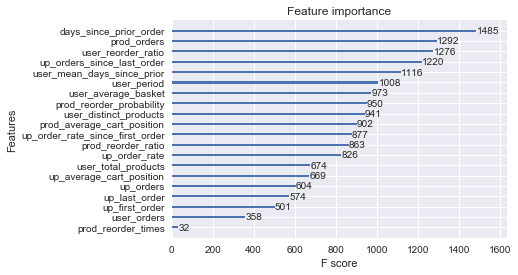

In [192]:
xgb.plot_importance(xgb_model)

In [ ]:
xgb.plot_tree(xgb_model, num_trees=1)

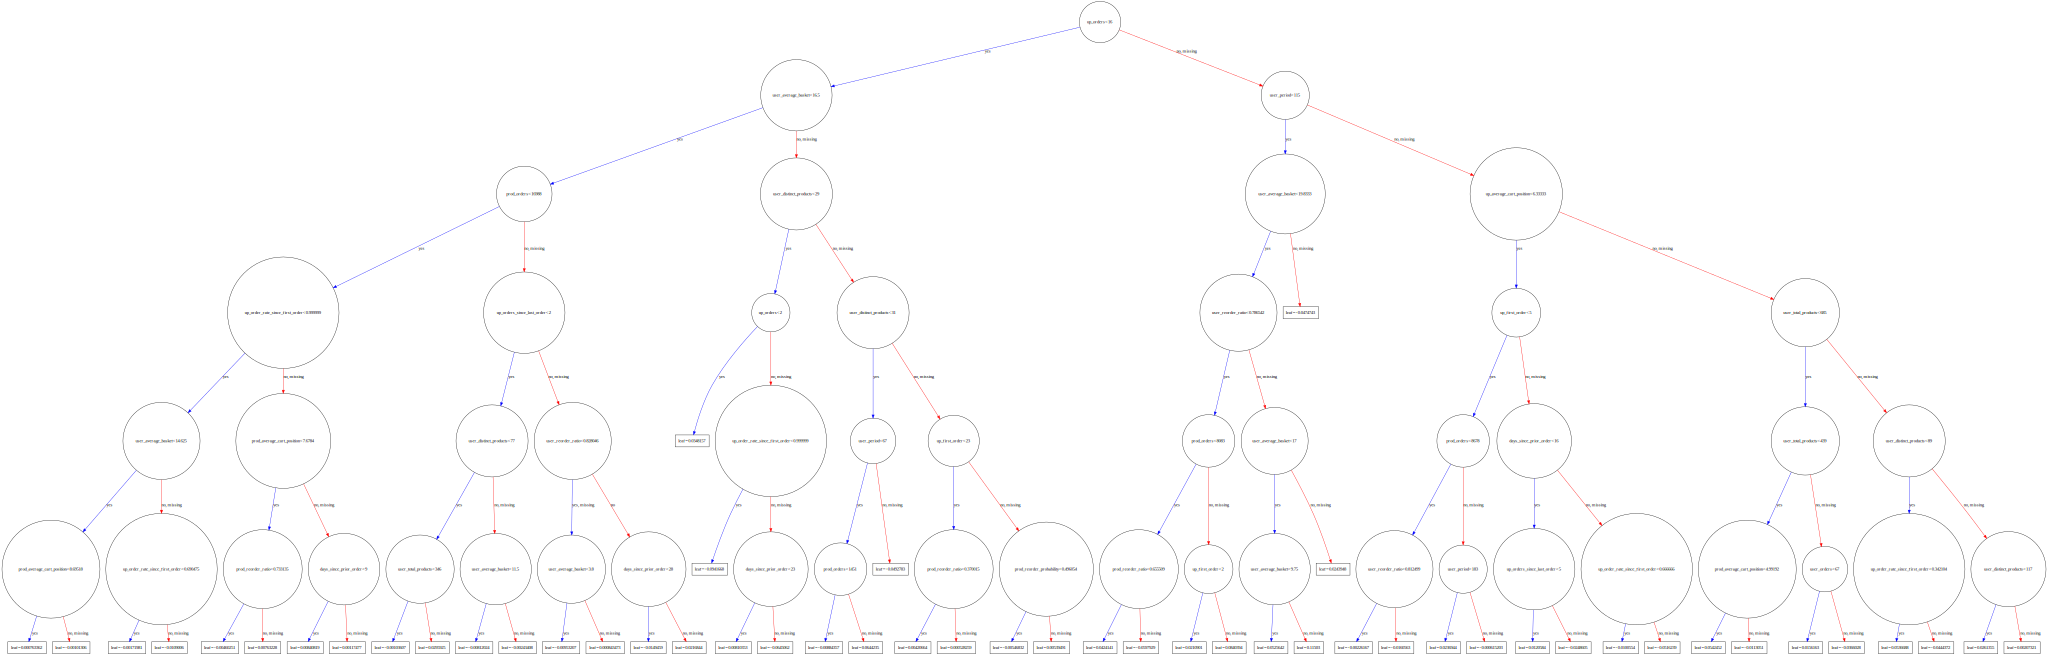

In [49]:
xgb.to_graphviz(xgb_model, num_trees=199)

In [200]:
X_test = test[test.columns.difference(['order_id', 'product_id'])]

In [201]:
X_test = X_test.drop(['reordered'], axis=1)

In [202]:
X_test.tail()

,days_since_prior_order,prod_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_ratio,prod_reorder_times,up_average_cart_position,up_first_order,up_last_order,up_order_rate,up_order_rate_since_first_order,up_orders,up_orders_since_last_order,user_average_basket,user_distinct_products,user_mean_days_since_prior,user_orders,user_period,user_reorder_ratio,user_total_products
4822283,30.0,4.195122,123,0.520000,0.593496,2.460000,1.0,1,3,1.0,1.0,3,0,1.0,1,30.000000,3,60.0,1.0,3
4822284,13.0,5.040179,224,0.277778,0.517857,2.074074,1.0,1,6,1.0,1.0,6,0,1.0,1,9.200000,6,46.0,1.0,6
4822285,27.0,4.234890,728,0.669421,0.833791,6.016529,1.0,1,3,1.0,1.0,3,0,1.0,1,7.000000,3,14.0,1.0,3
4822286,9.0,4.000000,39,0.833333,0.846154,6.500000,1.0,1,26,1.0,1.0,26,0,1.0,1,7.640000,26,191.0,1.0,26
4822287,30.0,6.090909,11,0.285714,0.363636,1.571429,1.0,1,4,1.0,1.0,4,0,1.0,1,26.333334,4,79.0,1.0,4


In [203]:
d_test = xgb.DMatrix(X_test)

In [204]:
test['reordered'] = xgb_model.predict(d_test)

In [205]:
test['reordered'].tail()

4822283    0.697897
4822284    0.833119
4822285    0.705970
4822286    0.912575
4822287    0.706005
Name: reordered, dtype: float32

In [206]:
print('formatting and writing to submission file ...')
prd_bag = dict()
for row in test.itertuples():
    if row.reordered > 0.21:   ## Cutoff for lableing product as positive (can be tweaked with cross validation)
#    if row.reordered > 0.25: 
        try:
            prd_bag[row.order_id] += ' ' + str(row.product_id)
        except:
            prd_bag[row.order_id] = str(row.product_id)

for order in test.order_id:
    if order not in prd_bag:
        prd_bag[order] = 'None'

submit = pd.DataFrame.from_dict(prd_bag, orient='index')

submit.reset_index(inplace=True)
submit.columns = ['order_id', 'products']
submit.to_csv('xgboost_submit21.csv', index=False)

formatting and writing to submission file ...


#### (3) Preprocessing for other algorithm (Random Forest, SVM, KNN)

In [53]:
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.metrics import auc
import matplotlib.pyplot as plt

a. Null 값 처리

In [54]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5665342 entries, 2143521 to 3335364
Data columns (total 20 columns):
days_since_prior_order             float64
prod_average_cart_position         float64
prod_orders                        int64
prod_reorder_probability           float64
prod_reorder_ratio                 float64
prod_reorder_times                 float64
up_average_cart_position           float64
up_first_order                     int64
up_last_order                      int64
up_order_rate                      float64
up_order_rate_since_first_order    float64
up_orders                          int64
up_orders_since_last_order         int64
user_average_basket                float64
user_distinct_products             int64
user_mean_days_since_prior         float64
user_orders                        int64
user_period                        float64
user_reorder_ratio                 float64
user_total_products                int64
dtypes: float64(12), int64(8)
memory 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ED18DA5908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001ED19D45C50>]], dtype=object)

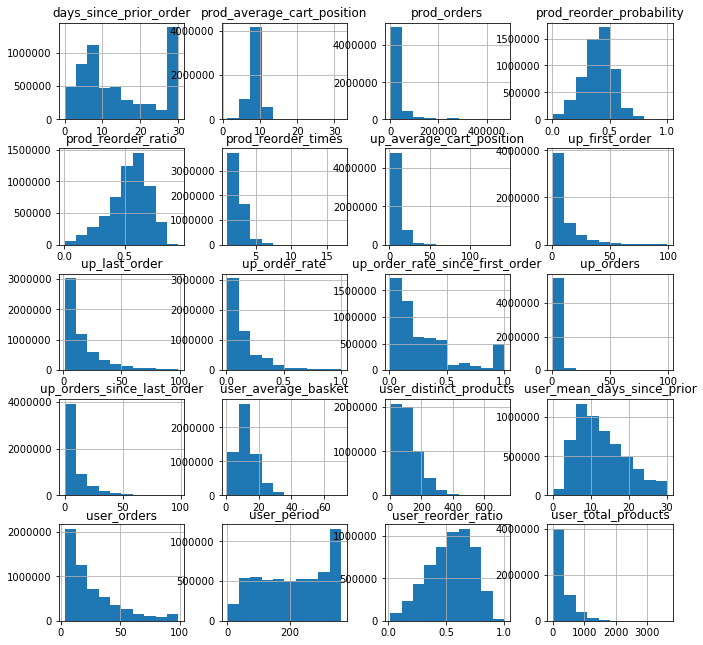

In [55]:
X_train[X_train.dtypes[(X_train.dtypes=="float64")|(X_train.dtypes=="int64")]
                        .index.values].hist(figsize=[11,11])

In [56]:
X_train.isnull().any()

days_since_prior_order             False
prod_average_cart_position         False
prod_orders                        False
prod_reorder_probability           False
prod_reorder_ratio                 False
prod_reorder_times                 False
up_average_cart_position           False
up_first_order                     False
up_last_order                      False
up_order_rate                      False
up_order_rate_since_first_order    False
up_orders                          False
up_orders_since_last_order         False
user_average_basket                False
user_distinct_products             False
user_mean_days_since_prior         False
user_orders                        False
user_period                        False
user_reorder_ratio                  True
user_total_products                False
dtype: bool

In [57]:
len(X_train[lambda x: x.user_reorder_ratio.isnull()])

20565

In [58]:
X_train['user_reorder_ratio'].fillna(0, inplace=True) 

In [59]:
X_eval.isnull().any()

days_since_prior_order             False
prod_average_cart_position         False
prod_orders                        False
prod_reorder_probability           False
prod_reorder_ratio                 False
prod_reorder_times                 False
up_average_cart_position           False
up_first_order                     False
up_last_order                      False
up_order_rate                      False
up_order_rate_since_first_order    False
up_orders                          False
up_orders_since_last_order         False
user_average_basket                False
user_distinct_products             False
user_mean_days_since_prior         False
user_orders                        False
user_period                        False
user_reorder_ratio                  True
user_total_products                False
dtype: bool

In [60]:
X_eval['user_reorder_ratio'].fillna(0, inplace=True) 

In [61]:
test.isnull().any()

product_id                         False
up_orders                          False
up_first_order                     False
up_last_order                      False
up_average_cart_position           False
prod_orders                        False
prod_reorder_probability           False
prod_reorder_times                 False
prod_reorder_ratio                 False
prod_average_cart_position         False
user_orders                        False
user_period                        False
user_mean_days_since_prior         False
user_total_products                False
user_reorder_ratio                  True
user_distinct_products             False
user_average_basket                False
order_id                           False
days_since_prior_order             False
up_order_rate                      False
up_orders_since_last_order         False
up_order_rate_since_first_order    False
reordered                          False
dtype: bool

In [62]:
test['user_reorder_ratio'].fillna(0, inplace=True)

b. Scaling

In [91]:
min_max_scaler = preprocessing.MinMaxScaler() # 0 ~ 1 범위로 scaling

In [64]:
X_train_scaled = min_max_scaler.fit_transform(X_train)

In [65]:
X_eval_scaled = min_max_scaler.fit_transform(X_eval)

c. Test Dataset format  

In [66]:
X_test = test[test.columns.difference(['order_id', 'product_id'])]

In [67]:
X_test = X_test.drop(['reordered'], axis=1)

In [89]:
X_test.columns

Index(['days_since_prior_order', 'prod_average_cart_position', 'prod_orders',
       'prod_reorder_probability', 'prod_reorder_ratio', 'prod_reorder_times',
       'up_average_cart_position', 'up_first_order', 'up_last_order',
       'up_order_rate', 'up_order_rate_since_first_order', 'up_orders',
       'up_orders_since_last_order', 'user_average_basket',
       'user_distinct_products', 'user_mean_days_since_prior', 'user_orders',
       'user_period', 'user_reorder_ratio', 'user_total_products'],
      dtype='object')

#### (4) SVM

In [ ]:
clf = svm.SVC() # hyperparameter C의 default 값1, 조절가능
svm_model = clf.fit(X_train_scaled, y_train)

In [ ]:
y_pred = clf.predict(X_eval)

#### (5) Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
clf = RandomForestClassifier(n_jobs = 4) 

In [71]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [ ]:
%%time
pred_y_eval = clf.predict(X_eval)

In [ ]:
pred_y_eval =pd.DataFrame(pred_y_eval)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_eval, pred_y_eval)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_pred = pd.DataFrame(y_pred)
y_pred.head()

In [ ]:
test['reordered'] = y_pred
test.tail()

In [ ]:
print('formatting and writing to submission file ...')
prd_bag = dict()
for row in test.itertuples():
    if row.reordered == 1:   
        try:
            prd_bag[row.order_id] += ' ' + str(row.product_id)
        except:
            prd_bag[row.order_id] = str(row.product_id)

for order in test.order_id:
    if order not in prd_bag:
        prd_bag[order] = 'None'

submit = pd.DataFrame.from_dict(prd_bag, orient='index')

submit.reset_index(inplace=True)
submit.columns = ['order_id', 'products']
submit.to_csv('random_forest_submit.csv', index=False)

#### (6) KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, n_jobs = 4)

In [ ]:
%%time
knn.fit(X_train_scaled, y_train)

In [ ]:
pred_y_eval = knn.predict(X_eval_scaled)

In [ ]:
accuracy_score(y_eval, pred_y_eval)

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
y_pred = pd.DataFrame(y_pred)
y_pred.head()

In [ ]:
test['reordered'] = y_pred
test.tail()

In [ ]:
print('formatting and writing to submission file ...')
prd_bag = dict()
for row in test.itertuples():
    if row.reordered == 1:   ## Cutoff for lableing product as positive (can be tweaked with cross validation)
        try:
            prd_bag[row.order_id] += ' ' + str(row.product_id)
        except:
            prd_bag[row.order_id] = str(row.product_id)

for order in test.order_id:
    if order not in prd_bag:
        prd_bag[order] = 'None'

submit = pd.DataFrame.from_dict(prd_bag, orient='index')

submit.reset_index(inplace=True)
submit.columns = ['order_id', 'products']
submit.to_csv('knn_submit.csv', index=False)

### 4. 총평

(아쉬운 점)
 * SVM(Support Vector Machine), KNN - fit, predict 과정에서 시간이 오래 걸려 수행해보지 못함.
 * Hyper-parameter 의 최적값을 찾기 위한 Cross Validation을 수행해보지 못하였음.

(더 고려해볼 점)
* 기존 구매 이력을 활용해 재구매가 아닌, 새로운 product의 구매를 추천할 수 있지 않을까라는 생각을 해봄.  
  -> CF(Collaborative Filtering) 알고리즘 등을 이용해서, 추천 시스템을 구현해 볼 수도 있을 것임.  
     (User 간, Product간 유사도 측정 통해 새롭게 구매할 제품을 예측하는 방식)